<a href="https://colab.research.google.com/github/Nautyy9/fashion_mnist/blob/main/Fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAvgPool2D,GlobalAveragePooling2D, Activation, Layer, Conv2D,LayerNormalization,MultiHeadAttention, BatchNormalization,Add, Flatten,Embedding ,MaxPool2D,Dense,InputLayer
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential, Model
from tensorflow.keras.losses import CategoricalCrossentropy

import tensorflow_datasets as tfds
import albumentations as A
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import LabelEncoder

#Config

In [ ]:
config ={
    "im_size" : 224,
    "batch_size" : 32,
    "epochs" : 20,
    "patch_size" : 2,
}
Classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#TFDS

## Downloading/Preparing Dataset

In [ ]:
# By using as_supervised=True, you can get a tuple (features, label) instead for supervised datasets.

dataset, dataset_info = tfds.load("fashion_mnist", split=["train"] , with_info=True, as_supervised=True, shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompletePVRGRI/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompletePVRGRI/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [ ]:
dataset_info

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path=PosixGPath('/tmp/tmpvhmacn6rtfds'),
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao a

In [ ]:
def train_test_split(train_ratio, val_ratio):
  dataset_length = len(dataset[0])

  train_dataset = dataset[0].take(int(train_ratio*dataset_length))
  val_dataset_20_percent = dataset[0].skip(int(train_ratio*dataset_length))
  val_dataset = val_dataset_20_percent.take(int(val_ratio*dataset_length))
  test_dataset = val_dataset_20_percent.skip(int(val_ratio*dataset_length))

  return train_dataset, val_dataset, test_dataset

In [ ]:
train_ratio =0.8
val_ratio =0.1
test_ratio =0.1
train_dataset, val_dataset, test_dataset = train_test_split(train_ratio, val_ratio)

In [ ]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
val_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
test_dataset

<_SkipDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
train_dataset = train_dataset.map(lambda x,y : (x,tf.one_hot(y, depth = 10)))
val_dataset = val_dataset.map(lambda x,y : (x, tf.one_hot(y,depth=10)))

## Plotting

---
> Plotting tensorflow dataset


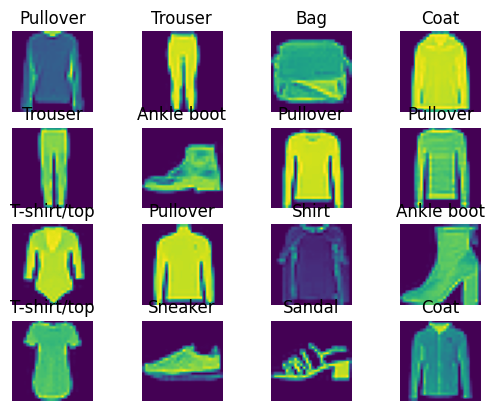

In [ ]:
for i,(image, label) in enumerate(train_dataset.take(16)):
  # looping was giving me error about float and int i.e, why i've converted it into integer and also giving me error about scalar array i.e, only integer scalar arrays can be converted to a scalar index i.e, i've converted to .numpy()-->numpy array
  for index , index_value in enumerate(tf.cast(label, dtype=tf.int32).numpy()):
    if(index_value == 1):
      label_name = Classes[index]
  plt.subplot(4,4,i+1)
  plt.title(label_name)
  plt.axis("off")
  plt.imshow(image)

In [ ]:
# for (img, label) in  train_dataset.take(16):
#   print(label)

In [ ]:
# Method for extracting total number of classes to a list
yoho= dataset_info.features["label"].num_classes
labels = []
for class_index in range(yoho):
    class_label = dataset_info.features["label"].int2str(class_index)
    labels.append(class_label)

print(labels)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [ ]:
# converting labels to integer just to represent the labels as integer --> this is just for learning as it has no use because , our dataset must be returning a labeled array for the dataset , we just have to make it categorical
# label_encoder =LabelEncoder()
# labeled_list_int = label_encoder.fit_transform(labels)
# print(labeled_list_int)

## Rescaling

---
>It is neccessary to convert uint8 to float32 or float64 because uint is not allowed type to model layers
>>Value passed to parameter 'input' has DataType uint8 not in list of allowed values: float16, bfloat16, float32, float64, int32
>>>Call arguments received by layer 'conv2d_9' (type Conv2D):
 • inputs=tf.Tensor(shape=(None, 28, 28, 1), dtype=uint8)



In [ ]:
# tf.config.run_functions_eagerly(True)
# print(tf.executing_eagerly())
def rescaling(image, label):
  print(type(image))
  # image_1 = tf.image.resize(image, size=(256,256))/255.
  # image_1 = tf.cast(image_1, dtype=tf.float32)
  # image_1 = img_to_array(image)

  # image_1 = cv2.cvtColor(np.array(image_1), cv2.COLOR_GRAY2RGB)
  # print(type(image_1))
  return image, label
  # image= tf.cast(image, dtype=tf.float32)
  # label= tf.cast(label, dtype=tf.float32)
  # image_1 =  tf.make_tensor_proto(image_1)
  # image_np = tf.make_ndarray()
  # image_1 = np.array(image_1, dtype="float32")

  # image = image/255.0
  # donot do this for labels because labels are 0 or 1 representing the classes of cloth


In [ ]:
yoo =  train_dataset.apply(rescaling)

TypeError: ignored

In [ ]:
train_dataset = train_dataset.map(rescaling)
val_dataset =   val_dataset.map(rescaling)
test_dataset =  test_dataset.map(rescaling)

False
<class 'tensorflow.python.framework.ops.Tensor'>
False
<class 'tensorflow.python.framework.ops.Tensor'>
False
<class 'tensorflow.python.framework.ops.Tensor'>


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [ ]:
tens = tf.constant([[1, 0.4], [1.5, 1.4]], dtype=tf.float32)
print(type(tens))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
val_dataset

<_MapDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(10,), dtype=tf.float32, name=None))>

## Expanding Dimension

In [ ]:
# this is enough for expanding the dimension

train_dataset = train_dataset.shuffle(buffer_size=32).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=32).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

## Augementations

### Resizing and Batching

In [ ]:
# for image, label in train_dataset.take(1):
#   image=  tf.cast(image, dtype=tf.float32)
#   image = image/255.0
#   image= tf.cast(image, dtype=tf.uint32)
#   # print(image)

In [ ]:
# train_dataset = train_dataset.map(resize_rescale)
# val_dataset = val_dataset.map(resize_rescale)
# test_dataset = test_dataset.map(resize_rescale)


In [ ]:
# train_dataset = train_dataset.shuffle(buffer_size = 32, reshuffle_each_iteration=True).batch(config["batch_size"]).prefetch(tf.data.AUTOTUNE)
# val_dataset = val_dataset.shuffle(buffer_size = 32, reshuffle_each_iteration=True).batch(config["batch_size"]).prefetch(tf.data.AUTOTUNE)


### Albumentations

In [ ]:
# transforms = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.2),
# ])

In [ ]:
# def aug_albument(dataset):
#   images,labels = train_dataset.take(2)

#   dataset =  {"image": images}
#   print(images)
#   images = transforms(**dataset)
#   print(images)

#   image = images["image"]
#   print(image, 'after getting image index')
#   # casting img to float
#   image = tf.cast(image/255., tf.float32)
#   return image

In [ ]:
# def preprocess_images(images, labels):
#   images = tf.numpy_function(func = aug_albument, inp = [image], Tout = tf.float32)
#   return images, labels

In [ ]:
# train_dataset = train_dataset.map(preprocess_images)

In [ ]:
# im, _ = next(iter(train_dataset))
# plt.imshow(im[0])

In [ ]:
# for img, label in train_dataset.take(32):
#   print("toho")


In [ ]:
# plt.figure(figsize=(15,15))

# for i in range(1,32):
#   plt.subplot(8,4,i)
#   plt.imshow(img[i])

## Training

In [ ]:
class custom_model(tf.keras.Model):
  def __init__(self ):
    super(custom_model, self).__init__()
    self.conv2d = Conv2D(64, 3, padding="same" , kernel_initializer="he_uniform" , activation="relu")
    self.max_pool= MaxPool2D(pool_size=(2,2))
    self.flat = Flatten()
    self.dense1 = Dense(100, activation="relu")
    self.output_layer = Dense(10, activation="softmax")
# training param is we use in all layers to making default training
  def call(self, x, training=False):
    x= self.conv2d(x)
    x= self.max_pool(x)
    x=self.flat(x)
    x=self.dense1(x)

    return self.output_layer(x)

In [ ]:
model =  custom_model()
model(tf.zeros([1,28,28,1]), training=False)
model.summary()

Model: "custom_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  640       
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense_24 (Dense)            multiple                  1254500   
                                                                 
 dense_25 (Dense)            multiple                  1010      
                                                                 
Total params: 1,256,150
Trainable params: 1,256,150
Non-trainable params: 0
____________________________________________

In [ ]:
model.compile(
    metrics=["accuracy"],
    loss=CategoricalCrossentropy(),
    optimizer=SGD(),
)

In [ ]:
# def batching(image, label):
#   image = tf.expand_dims(image, axis=0)
#   label= tf.expand_dims(label, axis=0)
#   return image, label

In [ ]:
# train_dataset = train_dataset.map(batching)
# val_dataset = val_dataset.map(batching)

In [ ]:
model.fit(train_dataset, validation_data= val_dataset, epochs=config["epochs"], verbose=1)

Epoch 1/20
1500/1500 [==============================] - ETA: 0s - loss: 0.5399 - accuracy: 0.8052

KeyboardInterrupt: ignored

### Saving Model/Connecting to Drive

In [ ]:
# ERROR SAVING MODEL
# Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.
# model.save("tfds_fmnist.h5")
tf.keras.saving.save_model(model, "/content/tfds_fmnist")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# KERAS DATASET

## Loading Dataset

In [ ]:
# from keras.datasets import fashion_mnist
(train_dataset, train_labels), (val_dataset, val_labels) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
Classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
train_dataset

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [ ]:
# train_labels = tf.keras.utils.to_categorical(labeled_list_int)
print(train_labels)

[9 0 0 ... 3 0 5]


In [ ]:
import numpy as np
train_dataset = np.reshape(train_dataset,  (train_dataset.shape[0], 28,28,1))
val_dataset = np.reshape(val_dataset ,(val_dataset.shape[0], 28,28,1))

## Plot


### Converting train_dataset to tensor

---


> I tried to do it because my previous plot is on tensorflow based which was element_spec datatype having 2 TensorSpec datatype 1-> for Image Tensor which of type(uint8) and other of the corresponding label which is of type(int)

> The label int value is mapped with the string list of classes



In [ ]:
# train_dataset_sample = tf.convert_to_tensor(train_dataset)

In [ ]:
# train_dataset_sample=  tf.expand_dims(train_dataset_sample, axis=-1)

In [ ]:
# train_dataset_sample

### Creating plot with numpy nd_array

---
> The plotting is done before reshaping image size to 224 and before making labels to categorical because it will make the plot mapping difficult



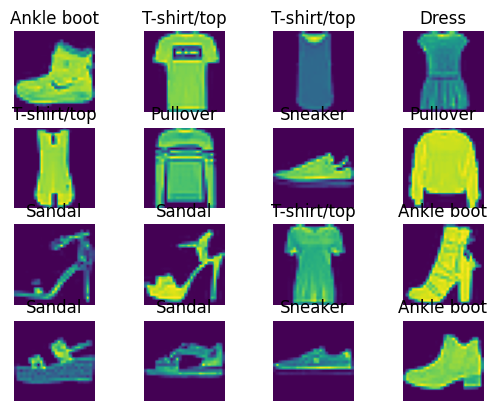

In [ ]:
for i , (image, labels) in enumerate(zip(train_dataset[:16], train_labels[:16])):
  plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.axis('off')
  plt.title(Classes[labels])


# earlier i was doing the below iterating , now the problem with this is , it is not producing the images --> why ?
# because the shape of train_dataset is (6000, 28,28,1 ---> total_images/batch, width, height, dimension) & what i was doing is shape[0][:16] which instead of iterating over 16 images sample was iterating over the 16 points width list  hence i changes to just [:16],
# i caught the error because of image.shape  ----> advice ---> always print the shape or tensor

# for i , (image, labels) in enumerate(zip(train_dataset[0][:16], train_labels[:16])):
#   print("image", "--->", image,"label" ,"------>", labels)
#   print(image.shape)
#   plt.subplot(4,4,i+1)
#   plt.imshow(image)
#   plt.axis('off')
#   plt.title(Classes[labels])

### Pixalating/Resizing the Train and Test image

---

> I can also do that with tf.reshape which would make it much easier but just to keep it simple i have made a function

In [ ]:
def prep_pixels(train, test):
 # convert from integers to floats
 train_norm = train.astype('float32')
 test_norm = test.astype('float32')
 # normalize to range 0-1
 train_norm = train_norm / 255.0
 test_norm = test_norm / 255.0
 # return normalized images
 return train_norm, test_norm

In [ ]:
train_dataset,val_dataset = prep_pixels(train_dataset,val_dataset)

In [ ]:
train_dataset.shape

(60000, 28, 28, 1)

In [ ]:
val_dataset.shape

(10000, 28, 28, 1)

In [ ]:
train_labels.shape

(60000,)

In [ ]:
val_labels.shape

(10000,)

In [ ]:
train_labels = tf.keras.utils.to_categorical(train_labels)
val_labels = tf.keras.utils.to_categorical(val_labels)

In [ ]:
train_labels.shape

(60000, 10)

In [ ]:
val_labels.shape

(10000, 10)

## Training

In [ ]:
# if the error is model is haven't build yet ->that means there's no input layer or being provided to it, make sure to add Input Layer

lenet_model = Sequential([
    InputLayer(input_shape=(28,28,1)),
    Conv2D(32, 3,kernel_initializer="he_uniform", activation="relu"),
    MaxPool2D(pool_size=(2,2)),
    Flatten(),
    Dense(100, activation="relu"),
    Dense(10, activation="softmax"),
])
lenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 100)               540900    
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
__________________________________________________

In [ ]:
#for categorical dataset -->categorical crossentropy for binary dataset ->binary_crossentropy
lenet_model.compile(
    optimizer=GD(),
    loss=CategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [ ]:
history = lenet_model.fit(train_dataset,train_labels,validation_data=(val_dataset,val_labels),epochs=config["epochs"],verbose=1)

Epoch 1/20
1875/1875 [==============================] - 18s 4ms/step - loss: 0.5580 - accuracy: 0.8018 - val_loss: 0.4375 - val_accuracy: 0.8440
Epoch 2/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4011 - accuracy: 0.8585 - val_loss: 0.4097 - val_accuracy: 0.8513
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3554 - accuracy: 0.8746 - val_loss: 0.3659 - val_accuracy: 0.8650
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3236 - accuracy: 0.8845 - val_loss: 0.3566 - val_accuracy: 0.8717
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3028 - accuracy: 0.8922 - val_loss: 0.3177 - val_accuracy: 0.8879
Epoch 6/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2853 - accuracy: 0.8975 - val_loss: 0.3096 - val_accuracy: 0.8893
Epoch 7/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2705 - accuracy: 0.9029 - val_loss: 0.2978 - val_accuracy

### Saving the model/Connecting Google Drive


In [ ]:
lenet_model.save("GCD.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# VITS

In [ ]:
import cv2
test_image =cv2.imread("/content/sample_image.png")
# test_image = test_image.astype("float32")
test_image = cv2.resize(test_image, (28,28))
print(test_image.shape)

(28, 28, 3)


In [ ]:
# make sure that image images size must be 256 because only then our patches can be divided into 16x16
# ex our img size was 28,28 prev , hence if we want a 16*16 patches for 28,28 size it would just be 1 leaving rest 12,12 remaining from 28,28

patches = tf.image.extract_patches(
    images = tf.expand_dims(test_image, axis=0),
    sizes = [1, 2, 2, 1],
    strides = [1, 2, 2, 1],
    rates=[1,1,1,1],
    padding="VALID",
)

In [ ]:
# here for sample image i've channel of 3 so 2x2 pixels of each patch of 3 channels i would've 12 =2x2x3
# but instead in reshape i just used 2x2 = 4 so what reshape does it , multiply the 3 with 196 or say middle indicies = 588, make sure to use correct number of channels based on i/p image channel else they'll be multiplied with other indicies

print(patches.shape)
patches = tf.reshape(patches, (patches.shape[0], -1, 12))
print(patches.shape)

(1, 14, 14, 12)
(1, 196, 12)


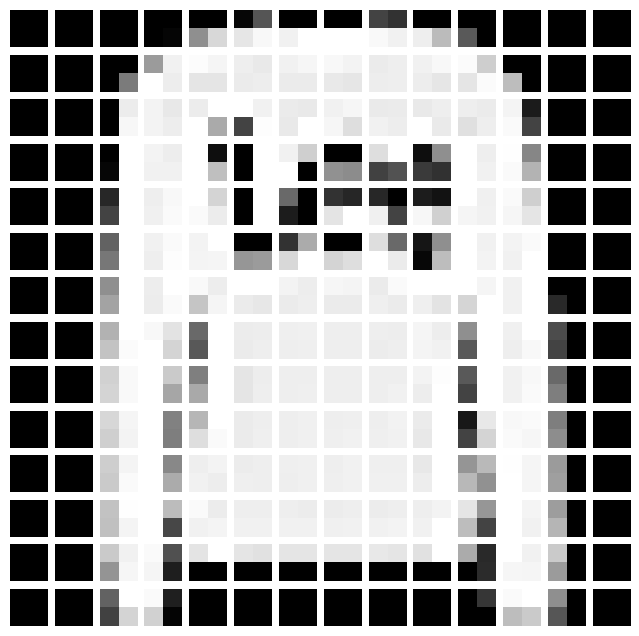

In [ ]:
plt.figure(figsize = (8,8))

for i in range(patches.shape[1]):

    ax = plt.subplot(14,14, i+1)
    plt.imshow(tf.reshape(patches[0,i,:], (2,2,3)))
    plt.axis("off")


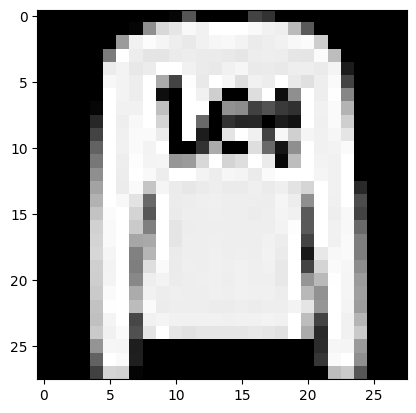

In [ ]:
plt.imshow(test_image)
axis="off"

In [ ]:
class PatchEncoder(Layer):
  def __init__(self, N_PATCHES, HIDDEN_SIZE):
    super(PatchEncoder, self ).__init__(name="patcher")
    # N_PATHCES =196, HIDDEN_SIZE = 4
    self.n_patches = N_PATCHES
    self.linear_projections = Dense(HIDDEN_SIZE)
    self.positional_embeddings = Embedding(N_PATCHES, HIDDEN_SIZE)

  def call(self, x):
    patches = tf.image.extract_patches(
                      images = x,
                      sizes = [1, 2, 2, 1],
                      strides = [1, 2, 2, 1],
                      rates=[1,1,1,1],
                      padding="VALID",
                  )
    # pathces.shape[-1] would give us more fine control over manually specifying 4 , because our image sample coould be of 3 channels or just 1 channels which leads to different values.
    print(patches.shape)
    patches_reshape = tf.reshape(x, (tf.shape(patches)[0], 196, patches.shape[-1]))
    # embeddings is just count to the total number of patches = 196
    embedding_input  = tf.range(start=0, limit=self.n_patches , delta=1)
    output = self.linear_projections(patches_reshape) + self.positional_embeddings(embedding_input)

    return output


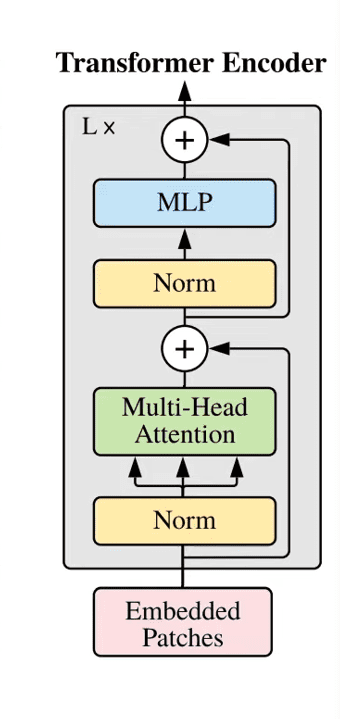

In [ ]:
class TransEncoder(Layer):
  def __init__(self, N_HEADS, HIDDEN_SIZE):
    super(TransEncoder,self).__init__(name="transformer")

    self.norm1 = LayerNormalization()
    self.norm2 = LayerNormalization()
    self.multi_head = MultiHeadAttention(N_HEADS, HIDDEN_SIZE)
    self.dense1 = Dense(HIDDEN_SIZE , activation=tf.nn.gelu)
    self.dense2 = Dense(HIDDEN_SIZE, activation=tf.nn.gelu)

  def call(self, input):
    x = self.norm1(input)
    x = self.multi_head(x, x)
    # Add layer takes
    x_1 = Add()([input, x])
    x = self.norm2(x_1)
    x= self.dense1(x)
    output= self.dense2(x)
    x= Add()([output,x_1])

    # return output

In [ ]:
# the vit model comprise of 3 dense layers -> 2 dense taking in dense_params and 1 dense for output , with that it also has patch and trans Encoder , transEncoder repeats number of layer times

class ViT(Model):
  def __init__(self, N_HEADS, N_LAYERS, HIDDEN_SIZE, N_PATCHES, N_DENSE_UNITS):
    super(ViT, self).__init__()
    self.n_layers = N_LAYERS
    self.patch_encoder = PatchEncoder(N_PATCHES, HIDDEN_SIZE)
    self.trans_encoder = [TransEncoder(N_HEADS, HIDDEN_SIZE) for _ in range(N_LAYERS)]
    self.dense1 = Dense(N_DENSE_UNITS, activation=tf.nn.gelu)
    self.dense2 = Dense(N_DENSE_UNITS, activation=tf.nn.gelu)
    self.dense3 = Dense(len(Classes), activation="softmax")

  def call(self, input):
    x= self.patch_encoder(input)
    print(x)
    print(x.shape)

    # iterating over no. of layers to make each transformer have the value generated by patch_encoder
    for i in range(self.n_layers):
      x= self.trans_encoder[i](x)
    x=Flatten()(x)
    x = self.dense1(x)
    x = self.dense2(x)
    return self.dense3(x)


In [ ]:
vit = ViT(
    N_HEADS = 4, HIDDEN_SIZE = 4, N_PATCHES = 196,
    N_LAYERS = 2, N_DENSE_UNITS = 128)
vit(tf.zeros([1,28,28,1]))

(1, 14, 14, 4)
tf.Tensor(
[[[ 2.46722363e-02 -4.78543900e-02  2.65546702e-02 -3.70242000e-02]
  [ 8.10752064e-03 -2.35399604e-02  6.08699396e-03 -5.78790903e-03]
  [-1.95753332e-02 -3.72129194e-02 -4.44980152e-02 -2.19360236e-02]
  [ 2.82802694e-02 -3.41343433e-02 -4.30704132e-02  4.80217375e-02]
  [-3.78372781e-02  1.29825212e-02 -4.53786738e-02  4.97669317e-02]
  [ 1.93108954e-02 -3.36994529e-02  3.58836092e-02 -4.62893248e-02]
  [-3.12280655e-03 -9.61087644e-04 -4.64068651e-02  4.74816561e-03]
  [-5.26065752e-03 -1.81562901e-02  4.82123755e-02 -6.25163317e-03]
  [ 2.00706236e-02 -3.32737565e-02  1.48665346e-02  2.58289687e-02]
  [ 3.29027511e-02  4.72829454e-02 -1.09474435e-02 -2.22409852e-02]
  [-1.66872516e-02 -1.36917830e-02  4.82322834e-02  3.49358805e-02]
  [-3.81535776e-02 -5.65290451e-03 -4.26989906e-02  1.15913041e-02]
  [-1.63942091e-02 -4.72208150e-02  3.88819836e-02  1.54578127e-02]
  [-4.65101115e-02 -4.11122330e-02  1.28479116e-02 -8.65650177e-03]
  [-7.18054920e-03 -3.

ValueError: ignored

# RESNET

---
> We use the batching, pixalating and mapping to resize or rescale from prev models
> We've made a residual block class having 2 conv_layer 1 having 1 stride and 1 having 2 strides as we've in our model(from daigram) which we use in combination with class of ResNet having 1,3,4,6,3 conv architecture
>> In the below diagram we see that at starting we've , 1 conv_1 with 2 strides and 7 kernel_size then a MaxPool of pool_size (3,3) and strides =2 then  6 conv_2 then 8 conv_3 then 12 conv_4 and finally 6 conv_4 ending with MaxAvgPool, and finally a FC layer


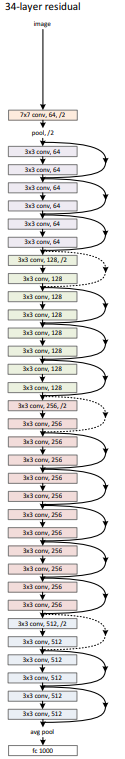
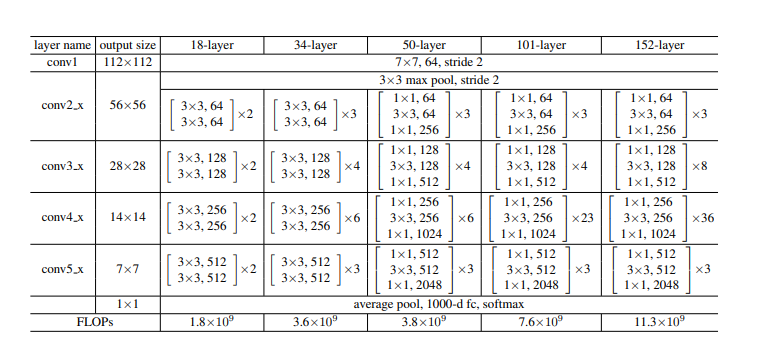

In [ ]:
# here will make custom layer just to make the mean and variance learned during the each dataset rather then using one which is learned during the training

class CustomConv2D(Layer):
  def __init__(self, n_filters,kernel_size, n_strides, activation,padding ):
    super(CustomConv2D, self).__init__()
    self.conv2D = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        strides = n_strides,
        activation = activation,
        padding = padding
    )
    self.batch_norm = BatchNormalization()

  def call(self, input, training=True):
    x=self.conv2D(input)
    x=self.batch_norm(x, training)
    output = x
    return output


In [ ]:
class ResidualBlock(Model):
  def __init__(self, n_filters, n_strides =1):
    super(ResidualBlock, self).__init__()
    self.strides_grtr_1 =  (n_strides != 1)
    # this we create for the first layer of the channel having strides == 2
    self.conv1 = CustomConv2D(n_filters, 3, n_strides, "relu", "same")
    # this we create for the rest layers of a block having same number of channels as the first layers
    self.conv2 =  CustomConv2D(n_filters, 3, 1, "relu", "same")
    # importing activation from Activation
    self.activation = Activation("relu")

    if(self.strides_grtr_1):
      # this is turn is required in case of extracting more features with less computation (in ex of copy we've seen that 5x5 filters gives 25 cost and 3x3 18 )
      self.conv_1x1 = CustomConv2D(n_filters, 1, n_strides, "relu", "same")



  def call(self, input , training):
    x=  self.conv1(input, training)
    x=  self.conv2(x, training)

    if self.strides_grtr_1 :
      x_add = self.conv_1x1(input, training)

      x_add = Add()([x, x_add])
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)

In [ ]:
class ResNet(Model):
  def __init__(self):
    super(ResNet , self).__init__()
    self.conv_1 = CustomConv2D(64, 7, 2 , padding="same", activation="relu")
    self.max_pool = MaxPool2D(pool_size =(3,3), strides = 2)

    self.conv2_1 = ResidualBlock(64)
    self.conv2_2 = ResidualBlock(64)
    self.conv2_3 = ResidualBlock(64)


    self.conv3_1 = ResidualBlock(128, 2)
    self.conv3_2 = ResidualBlock(128)
    self.conv3_3 = ResidualBlock(128)
    self.conv3_4 = ResidualBlock(128)

    self.conv4_1 = ResidualBlock(256, 2)
    self.conv4_2 = ResidualBlock(256)
    self.conv4_3 = ResidualBlock(256)
    self.conv4_4 = ResidualBlock(256)
    self.conv4_5 = ResidualBlock(256)
    self.conv4_6 = ResidualBlock(256)


    self.conv5_1 = ResidualBlock(512, 2)
    self.conv5_2 = ResidualBlock(512)
    self.conv5_3 = ResidualBlock(512)

    self.global_pool = GlobalAvgPool2D()
    self.fully_connected = Dense(10, activation="softmax")

  def call(self, x, training=True):
    x=self.conv_1(x)
    x=self.max_pool(x)

    x=self.conv2_1(x, training)
    x=self.conv2_2(x, training)
    x=self.conv2_3(x, training)

    x=self.conv3_1(x, training)
    x=self.conv3_2(x, training)
    x=self.conv3_3(x, training)
    x=self.conv3_4(x, training)

    x=self.conv4_1(x, training)
    x=self.conv4_2(x, training)
    x=self.conv4_3(x, training)
    x=self.conv4_4(x, training)
    x=self.conv4_5(x, training)
    x=self.conv4_6(x, training)

    x=self.conv5_1(x, training)
    x=self.conv5_2(x, training)
    x=self.conv5_3(x, training)

    x=self.global_pool(x)
    return self.fully_connected(x)


In [ ]:
resnet = ResNet()
resnet(tf.zeros([1, 28,28,1]), training=False)
resnet.summary()

Model: "res_net_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d_211 (CustomCo  multiple                 3456      
 nv2D)                                                           
                                                                 
 max_pooling2d_9 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 residual_block_20 (Residual  multiple                 74368     
 Block)                                                          
                                                                 
 residual_block_21 (Residual  multiple                 74368     
 Block)                                                          
                                                                 
 residual_block_22 (Residual  multiple                 7

# Transfer Learning

---
> The concept of using a pretrained_model to learn the new dataset defined by our model based on the previous results of the highly parameterized model
>> Although we are using previously defined model but we are not training our dataset on that model , for that we do fine_tuning  where we set our backbone.trainable = True

## EfficientNet

---
> In backbone we have to have the size of image having 3 channels plus the resolution must be greater than (32,32)
>>In our case the image size is (28,28,1), hence we've changed the resolution

In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights="imagenet",
    input_shape= (256,256,3)
)

In [ ]:
backbone.trainable =False

In [ ]:
efficientnet_model = tf.keras.Sequential([
    Input(shape=(256,256,3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense(64, activation="relu"),
    BatchNormalization(),
    Dense(128, activation="relu"),
    Dense(10, activation="softmax"),
])

In [ ]:
efficientnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 8, 8, 1792)       17673823  
                                                                 
 global_average_pooling2d_4   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 64)                114752    
                                                                 
 batch_normalization_4 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_13 (Dense)            (None, 128)               8320      
                                                                 
 dense_14 (Dense)            (None, 10)               

## MobileNet

---



In [ ]:
backbone = tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top = False,
    weights = "imagenet",
    input_shape = (224, 224, 3),
)

In [ ]:
pretrained_model = tf.keras.Sequential([
    Input(shape = (256, 256,3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense( 64, activation = "relu"),
    BatchNormalization(),
    Dense( 128, activation = "relu"),
    Dense( 10, activation = "softmax"),

    ])
pretrained_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_15 (Dense)            (None, 64)                81984     
                                                                 
 batch_normalization_5 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_16 (Dense)            (None, 128)               8320      
                                                      

## Fine Tuning EfficientNet

---



In [ ]:
backbone.trainable = True

In [ ]:
input = Input(shape = (256, 256,3) )

x = backbone(input, training = False)
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation = "relu")(x)
x = BatchNormalization()(x)
x = Dense(128, activation = "relu")(x)
output = Dense(1, activation = "softmax")(x)
finetuned_model = Model(input, output)

In [ ]:
finetuned_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_7   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_21 (Dense)            (None, 64)                81984     
                                                                 
 batch_normalization_7 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                           

In [ ]:
def pixalating(image, label):
  print(type(image))
